# House prices: in-depth feature engineering + XGB

The aim of this notebook is to estimate house prices based on their characteristics. I think this competition is a **great starting point for anyone interested in feature engineering and data cleaning**, given the simplicity of the dataset but the considerable amount of feature engineering that can be performed in order to improve the results.

Main workflow:
1. [Load data](#section1)
2. [Data exploration (EDA)](#section2)
3. [Missings cleaning](#section3)
4. [Feature engineering](#section4)
5. [Data preparation](#section5)
6. [Parametrization of the XGB model](#section6)
7. [Prediction and submit](#section7)

Let's start by importing the required libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from heapq import nlargest 
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# 1. Load data <a id="section1"></a>

Read the files provided by the Kaggle competition: train, test and sample_submission.

In [2]:
sample_submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 2. Data exploration (EDA) <a id="section2"></a>

There are 81 columns in the original dataset. A big fraction of this columns seems to have null values, and there are different types of data (categorical, numerical, date related information, etc). Hence, we will analyze these features to look for high correlations with the target column (SalePrice), potential outliers and meaningful insights that could help us to engineer some additional features.

Summary of the EDA step:
* Define which columns are categorical or numerical
* Generate a correlation matrix to detect potential dependencies between data columns
* Analyze discrete/categorical columns and drop outliers
* Analyze continuous important data and drop outliers

Categorical columns:
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Numerical columns:
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullB

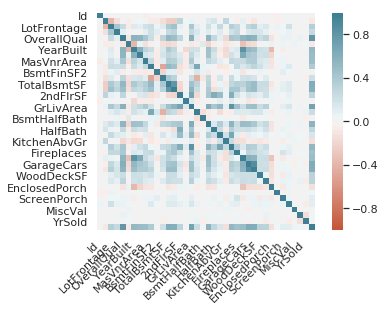

In [3]:
categorical = train.select_dtypes(include=['object']).columns
numerical = train.select_dtypes(include=['int64', 'float64']).columns

print("Categorical columns:")
print(categorical)
print("\nNumerical columns:")
print(numerical)

# Correlation matrix

print("\nCorrelations with SalePrice: ")
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Highest_corr = corr.nlargest(20, 'SalePrice')['SalePrice']
print(Highest_corr)

First we analyze discrete columns:

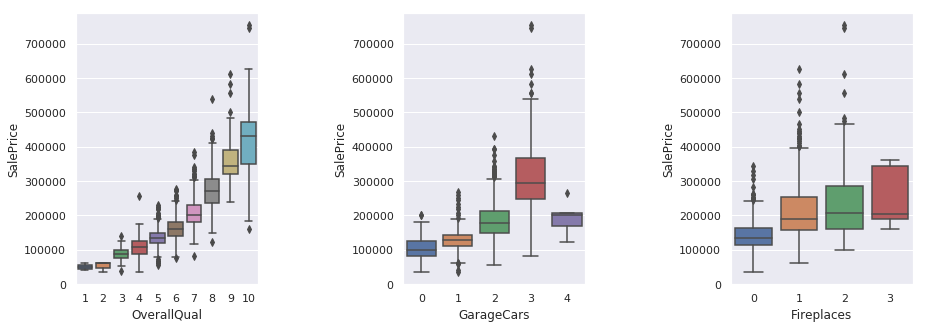

In [4]:
f1, axes = plt.subplots(1, 3, figsize=(15,5))
f1.subplots_adjust(hspace=0.4, wspace=0.8)
sns.boxplot(x=train['OverallQual'], y=train['SalePrice'],orient='v', ax=axes[0])
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'], orient='v', ax=axes[1])
sns.boxplot(x=train['Fireplaces'], y=train['SalePrice'], orient='v', ax=axes[2])

OverallQual and Fireplaces look fine, since the better the quality and number of fireplaces, the more expensive the house. However, a reasonable assumption is that the sale price of a house should be an increasing function of the garage cars capacity. 

Hence, GaraceCars = 4 is an outlier. Drop outliers with GarageCars = 4 and cheap SalePrice

In [5]:
train = train.drop(train[(train['GarageCars']>3) & (train['SalePrice']<300000)].index).reset_index(drop=True)

Let's continue analyzing other columns that may be correlated to SalePrice:

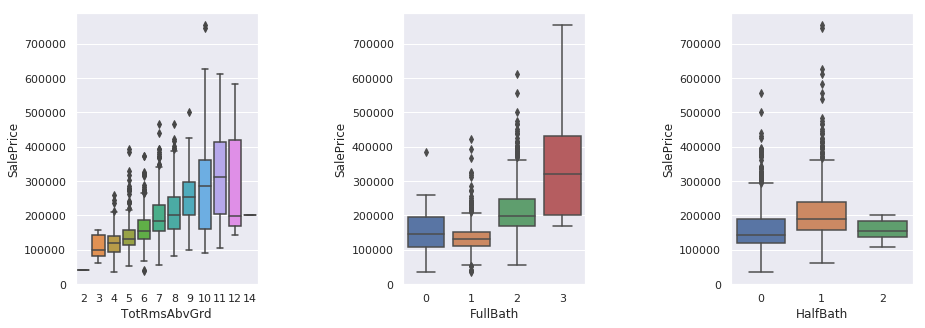

In [6]:
f2, axes = plt.subplots(1, 3, figsize=(15,5))
f2.subplots_adjust(hspace=0.4, wspace=0.8)
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'],orient='v', ax=axes[0])
sns.boxplot(x=train['FullBath'], y=train['SalePrice'], orient='v', ax=axes[1])
sns.boxplot(x=train['HalfBath'], y=train['SalePrice'], orient='v', ax=axes[2])

Proceed with rest of data using jointplots

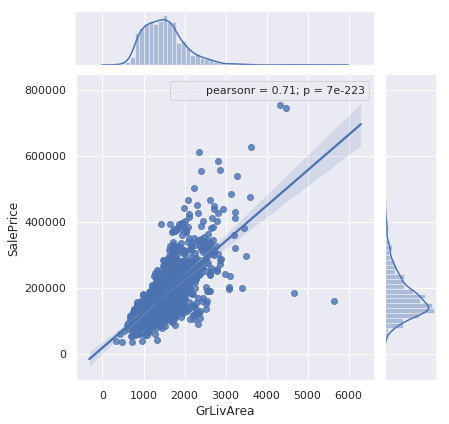

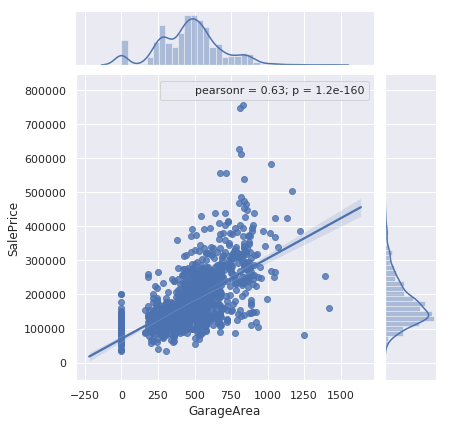

In [7]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)

Remove the two outliers on the bottom-right corner (high GrLivArea/GarageArea but cheap SalePrice)

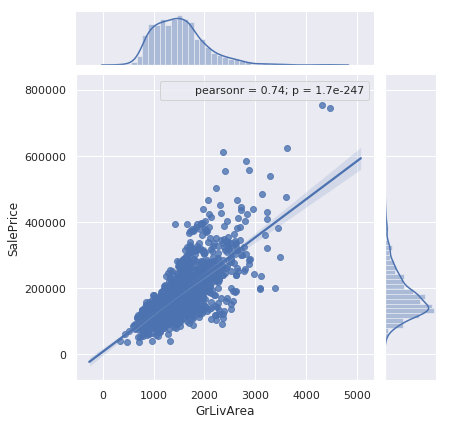

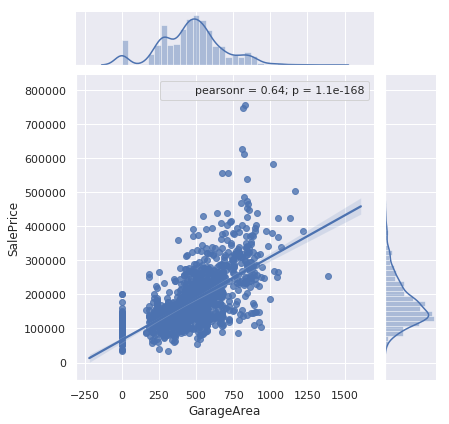

In [8]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index).reset_index(drop=True)
train = train.drop(train[(train['GarageArea']>1100) & (train['SalePrice']<200000)].index).reset_index(drop=True)
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)

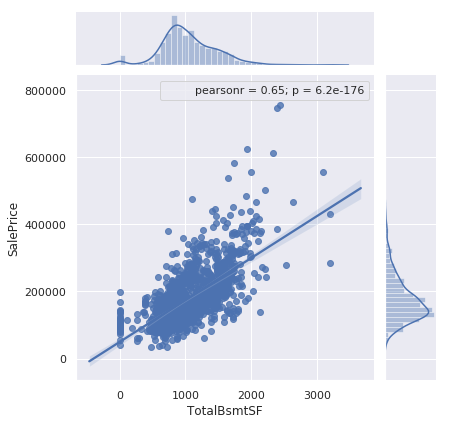

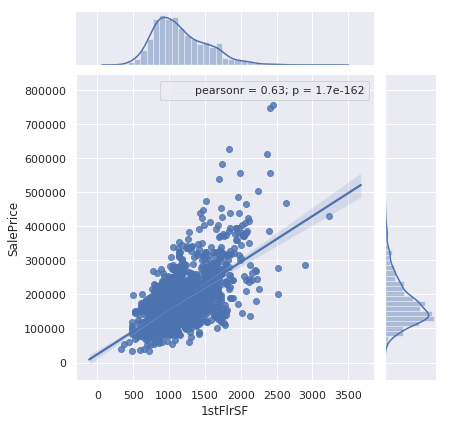

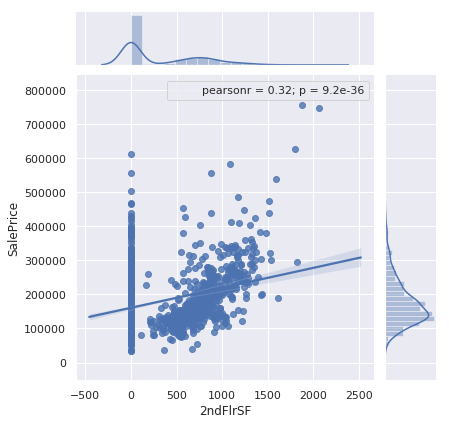

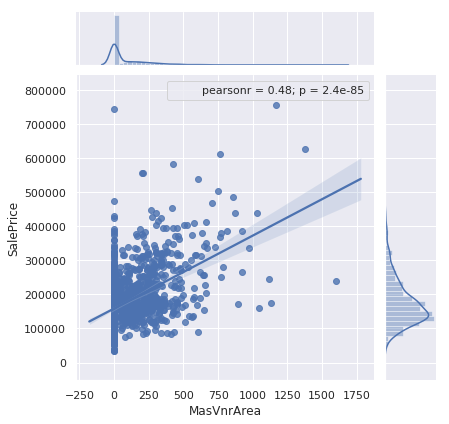

In [9]:
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['2ndFlrSF'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['MasVnrArea'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)

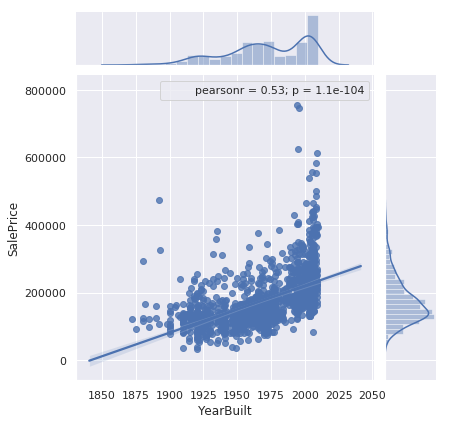

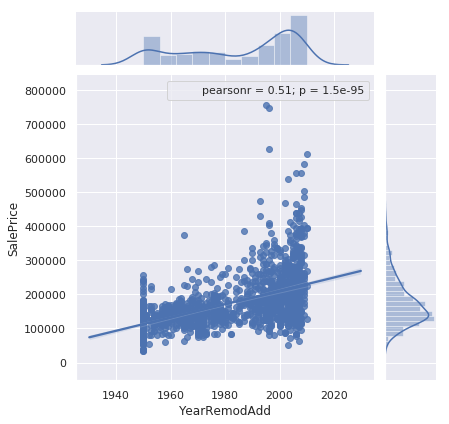

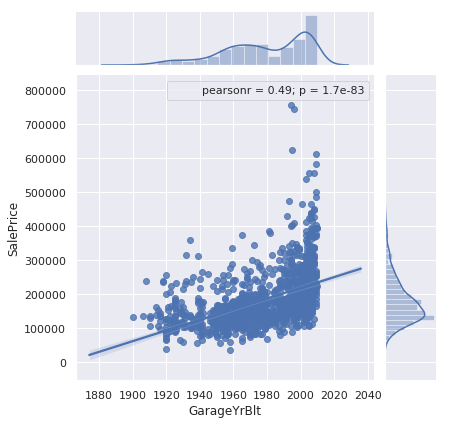

In [10]:
sns.jointplot(x=train['YearBuilt'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['YearRemodAdd'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['GarageYrBlt'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)

The following columns have poor corelation with SalePrice. It is expected to find a low Pearson coeff and hence we won't clean data from them.

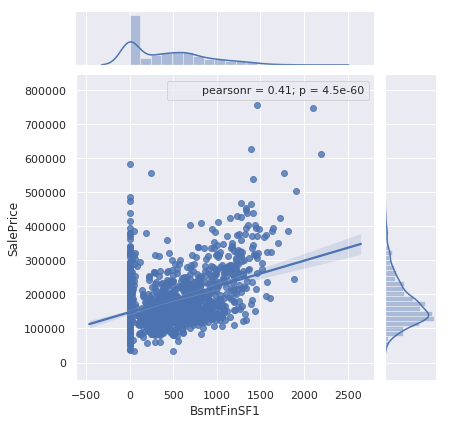

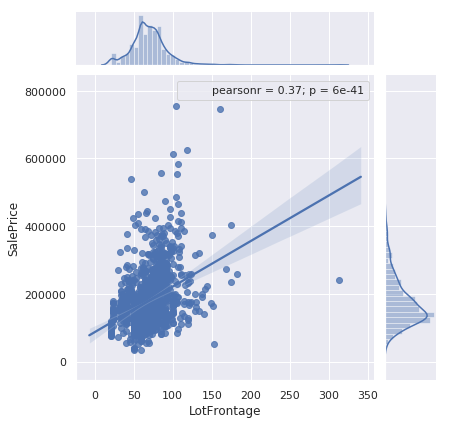

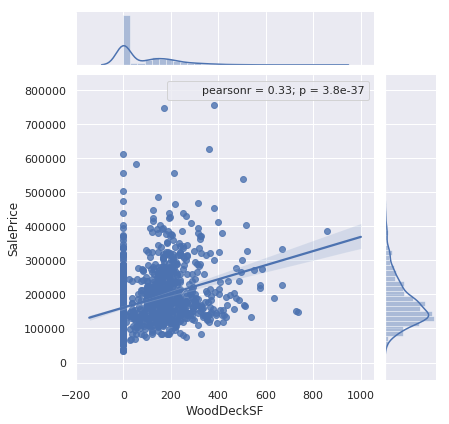

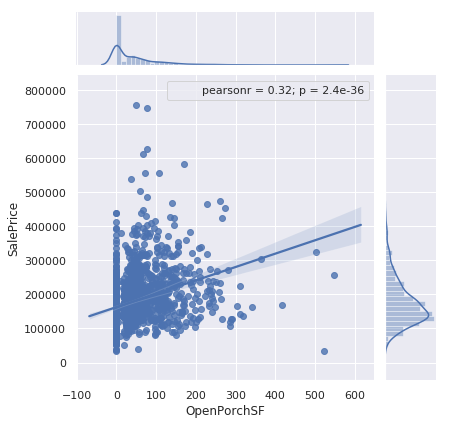

In [11]:
sns.jointplot(x=train['BsmtFinSF1'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['LotFrontage'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['WoodDeckSF'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)
sns.jointplot(x=train['OpenPorchSF'], y=train['SalePrice'], kind='reg').annotate(stats.pearsonr)

Once weird values and outliers have been removed from the training dataset, it's time to deal with missings and encoding

In [12]:
y_train = train.SalePrice
join_data = pd.concat((train, test), sort=False).reset_index(drop=True)
train_size = len(train)
test_size = len(test)

print("Train set size: ", train_size)
print("Test set size: ", test_size)
print("Train+test set size: ", len(join_data))

Train set size:  1452
Test set size:  1459
Train+test set size:  2911


# 3. Missings cleaning <a id="section3"></a>
 
From our data exploration, we know that there are several columns with missing data. We need to find out how many missings has each column, and how to deal with them. Since the nature of each column is different, we work [](http://)in-depth each of them while using the data_description.txt provided by the Kaggle competition to decide how to deal with them in each case.

Our main tasks are:
* Define number of missings for each data column
* Fill missings with the help of the data_description.txt file (manual and precise work)

Missings count in the train+test set:

In [13]:
missings_count = {col:join_data[col].isnull().sum() for col in join_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                 0
PoolQC        2902
MiscFeature   2807
Alley         2714
Fence         2341
SalePrice     1459
FireplaceQu   1416
LotFrontage    485
GarageYrBlt    159
GarageFinish   159
GarageQual     159
GarageCond     159
GarageType     157
BsmtCond        82
BsmtExposure    82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
MasVnrType      24
MasVnrArea      23
MSZoning         4
Utilities        2
BsmtFullBath     2
BsmtHalfBath     2
Functional       2
Exterior1st      1
Exterior2nd      1
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1


Most missings can be understood from the data_description.txt file (i.e. PoolQC missing means no pool). Let's fix this:

In [14]:
def fill_missings(data):
    clean_data = data.copy()

    # Replace missing categorical data with None (strings like Gd = Good, Wd = Wood, etc)
    fill_with_nones = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish',
          'GarageQual','GarageCond','BsmtExposure','BsmtQual','BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
          'MasVnrType']
    for col in fill_with_nones:
        clean_data[col] = clean_data[col].fillna("None")

    # Replace some numeric missings with 0
    fill_with_0 = ['MasVnrArea','BsmtFullBath','BsmtHalfBath','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','GarageArea','GarageCars','TotalBsmtSF','GarageYrBlt']
    for col in fill_with_0:
        clean_data[col] = clean_data[col].fillna(0)

    # Replace LotFrontage with neighborhood mean
    clean_data["LotFrontage"] = clean_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

    # When applies or doubting how to replace, use mode
    clean_data['MSZoning'].fillna(clean_data['MSZoning'].mode()[0])
    clean_data['Electrical'].fillna(clean_data['Electrical'].mode()[0])
    clean_data['Exterior1st'].fillna(clean_data['Exterior1st'].mode()[0])
    clean_data['Exterior2nd'].fillna(clean_data['Exterior2nd'].mode()[0])
    clean_data['KitchenQual'].fillna(clean_data['KitchenQual'].mode()[0])
    clean_data['SaleType'].fillna(clean_data['SaleType'].mode()[0])
    clean_data['Utilities'].fillna(clean_data['Utilities'].mode()[0])

    # Ad-hoc replacement of the Functional column
    clean_data['Functional'].fillna('Typ')
    
    return clean_data

# 4. Feature engineering <a id="section4"></a>

Alright, our data is now clean and we have more insight about data columns. However, a successful machine learning algorithm will need as much information as possible to improve its scoring. Hence, we will need to enrich a bit more our dataset.

What we will do:
* Create additional flag columns. Has_pool, has_garage, etc?
* Combine features. For example, Total_SF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
* Label encode categories
* Label encode numerical data that is in fact categorical. For example, FireplaceQu, which is a quality measurement

In [15]:
def create_additional_features(all_data):
        
    # Flags
    all_data['has_pool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has_2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has_garage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has_fireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has_bsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    
    # Combine features
    all_data['Year_BuiltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']
    all_data['Total_SF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'])
    all_data['Total_Bath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
    all_data['Total_porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF'])
    
    return all_data

OK, we have created several additional features that hopefully will help to improve the model's accuracy. Now we need tackle the label encoding.

But before that, there are 4 numerical columns that relate to "types" and hence should be considered categories:

In [16]:
def categorize_data(data):
    categorized_data = data.copy()
    categorized_data['MSSubClass'] = categorized_data['MSSubClass'].apply(str)
    categorized_data['OverallCond'] = categorized_data['OverallCond'].astype(str)
    categorized_data['YrSold'] = categorized_data['YrSold'].astype(str)
    categorized_data['MoSold'] = categorized_data['MoSold'].astype(str)
    
    return categorized_data

Some categorical columns refer to quality or type, and can be encoded into numeric values. We'll use a simple LabelEncoding, but TargetEncoding or CatBoost could perform better:

In [17]:
def encode_categories(data):

    all_data = data.copy()
    cols_to_encode = ('PoolQC', 'Alley', 'Fence', 'FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
            'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 
            'BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 
            'OverallCond', 'YrSold', 'MoSold')

    # Process columns and apply LabelEncoder to categorical features
    for c in cols_to_encode:
        lbl = LabelEncoder() 
        lbl.fit(list(all_data[c].values)) 
        all_data[c] = lbl.transform(list(all_data[c].values))
        
    return all_data

# 5. Data preparation <a id="section5"></a>

Fine, we are almost there. Once all previous functions are applied, data will be clean from missing values, enriched with additional features and encoded into numerical values. Let's just finish the last details and split the dataset.

Data preparation workflow:
* Apply all previous functions to fill misings, create new features and encode categories
* Split data set: train, validation and test
* Deal with additional outliers. From a posterior manual analysis
* Drop all columns that would lead to overfitting
* One hot encode pending categorical data if needed

In [18]:
# Preprocessing
all_data = fill_missings(join_data)
all_data = create_additional_features(all_data)
all_data = categorize_data(all_data)
all_data = encode_categories(all_data)

# Split again train-test data
X = all_data[:train_size]
X_test_full = all_data[train_size:]

print(len(all_data), len(X), len(X_test_full))

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Deal with additional outliers (from an in depth and manual analysis)
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

# Drop columns that would lead to overfitting (too much 0s)
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.99, test_size=0.01,
                                                                random_state=0)

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype not in ['int64', 'float64']]

print("Low cardinality columns: ", low_cardinality_cols)

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

print("Numeric columns: ", numeric_cols)

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

2911 1452 1459
Low cardinality columns:  ['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric columns:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'Enclos

Before going to the final detection, there's an additional problem to address. 

Wealth is a magnitude that follows a power law, and hence its distribution is not a normal distribution, and other colums may have similar behaviors. Since most machine learning algorithms -and definetly XGB is one of them- work better with normal distributions, we will analyze  highly non-normal distributed features with |skewness|>0.8.

We will modify them to be more "normally distributed". This can be done with several transformations, but I decided to use a simple logarithm.

In [19]:
skewed_feats = X_train[numeric_cols].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
y_train = y_train.apply(lambda x: np.log(x))
y_valid = y_valid.apply(lambda x: np.log(x))

# Apply log to all columns with |skewness|>0.8
log_col = []
for col in skewed_feats.index:
    if(abs(skewed_feats[col])>0.8): 
        log_col.append(col)
        X_train[col]=X_train[col].apply(lambda x: np.log(x))
        X_valid[col]=X_valid[col].apply(lambda x: np.log(x))
        X_test[col]=X_test[col].apply(lambda x: np.log(x))

# 6. Parametrization of the XGB model <a id="section6"></a>

Everything is ready for our final prediction. But first, we need to find the parameters that give the best accuracy. This is done by a simple grid search over 3 cross-validation folds.

In [20]:
def optimize_xgb(all_data): 
    xgb1 = XGBRegressor()
    parameters = {'nthread':[1], #when use hyperthread, xgboost may become slower
                  'objective':['reg:linear'],
                  'learning_rate': [.02, .01, .0075, .005], #so called `eta` value
                  'max_depth': [5, 6, 7],
                  'min_child_weight': [3, 4, 5],
                  'subsample': [0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators': [2500, 5000]}

    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv = 2,
                            n_jobs = 5,
                            verbose=True)

    xgb_grid.fit(X_train, y_train)

    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    
# optimize_xgb(all_data)

# 7. Prediction and submit <a id="section7"></a>

Finally, define the model with the best parameters, introduce the objective function to minimize (in this case the squared error) and submit the results. Notice that we will use a pipeline, just as a best practices guideline.

In [21]:
# Define model with best MAE
model = XGBRegressor(colsample_bytree=0.7, learning_rate=.01, max_depth=6, min_child_weight=3, n_estimators=3000, 
                     nthread=1, objective='reg:squarederror', subsample=0.7, random_state=21, 
                     early_stopping_rounds = 10, eval_set=[(X_valid, y_valid)], verbose=False)

In [22]:
# Train and test the model

print("Let's the training begin. Plase wait.")

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('model', model)])
my_pipeline.fit(X_train, y_train)

print("Training finished! Now let's predict test values.")

preds_test = my_pipeline.predict(X_test)
preds_test = [np.exp(pred) for pred in preds_test] 

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index+9,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

print("Everything finished correctly!")

print(output.SalePrice)

Let's the training begin. Plase wait.
Training finished! Now let's predict test values.
Everything finished correctly!
0       128194.742188
1       169013.203125
2       183980.015625
3       193400.375000
4       192297.250000
            ...      
1454     76968.390625
1455     81417.570312
1456    173335.031250
1457    113870.000000
1458    225804.750000
Name: SalePrice, Length: 1459, dtype: float64


In [23]:
print(len(test), len(X_test_full), len(output.SalePrice))

1459 1459 1459


Perfect! Our model is done and results submited. Now you can enjoy your results and play with parameters or additional feature engineering to obtain better results. Hope you enjoyed the kernel and see you soon!


## Optional code cells


All code cells below are completely optional. They help us to understand some changes done to data (i.e. skewness correction), see correlations and test alternative algorithms. 

Skewness: 1.891301
Kurtosis: 6.544838


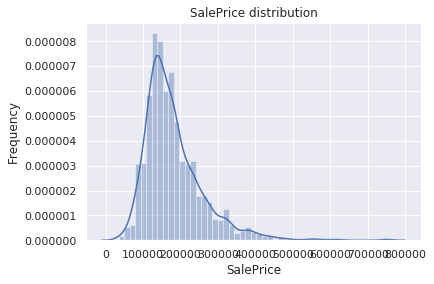

In [24]:
#Check the distribution of SalePrice
sns.distplot(y)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

ExterQual       -0.646997
BsmtQual        -0.597016
KitchenQual     -0.593068
GarageFinish    -0.428404
HeatingQC       -0.401575
BsmtExposure    -0.310255
LotShape        -0.254582
KitchenAbvGr    -0.139738
EnclosedPorch   -0.135251
PoolQC          -0.129704
BsmtFinType1    -0.098336
FireplaceQu     -0.096814
OverallCond     -0.080602
YrSold          -0.030029
LowQualFinSF    -0.025699
Id              -0.020329
MiscVal         -0.020293
BsmtHalfBath    -0.017773
BsmtFinSF2      -0.011541
MoSold           0.006815
Street           0.030252
3SsnPorch        0.044580
MSSubClass       0.047176
LandSlope        0.051716
BsmtFinType2     0.073003
Alley            0.080744
BsmtCond         0.096352
PoolArea         0.099586
has_pool         0.104096
ScreenPorch      0.111467
Functional       0.115618
ExterCond        0.118410
has_2ndfloor     0.136253
Fence            0.139982
has_bsmt         0.153106
BedroomAbvGr     0.167300
GarageQual       0.206428
BsmtUnfSF        0.215088
BsmtFullBath

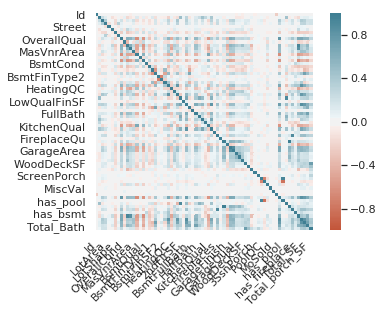

In [25]:
# Correlation matrix

corr = all_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Highest_corr = corr.nsmallest(40, 'SalePrice')['SalePrice']
print(Highest_corr)

In [26]:
"""
model=lgb.LGBMRegressor(
        n_estimators=3000,
        learning_rate=0.01,
        min_child_weight=3,
        #num_leaves=32,
        colsample_bytree=0.7,
        subsample=0.7,
        max_depth=5,
        #reg_alpha=0.04,
        #reg_lambda=0.073,
        #min_split_gain=0.0222415,
        verbose=1,
        seed=21)

# Bundle preprocessing and modeling code in a pipeline
model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1, early_stopping_rounds = 10)

print("Training finished! Now let's predict test values.")

preds_test = model.predict(X_test)
preds_test = [np.exp(pred) for pred in preds_test] 
# Cross validation accuracy for 3 folds
scores = cross_val_score(model, X_train, y_train, cv=3)
print(scores)

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index+9,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

print("Everything finished correctly!")

print(output.SalePrice)

"""

'\nmodel=lgb.LGBMRegressor(\n        n_estimators=3000,\n        learning_rate=0.01,\n        min_child_weight=3,\n        #num_leaves=32,\n        colsample_bytree=0.7,\n        subsample=0.7,\n        max_depth=5,\n        #reg_alpha=0.04,\n        #reg_lambda=0.073,\n        #min_split_gain=0.0222415,\n        verbose=1,\n        seed=21)\n\n# Bundle preprocessing and modeling code in a pipeline\nmodel.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1, early_stopping_rounds = 10)\n\nprint("Training finished! Now let\'s predict test values.")\n\npreds_test = model.predict(X_test)\npreds_test = [np.exp(pred) for pred in preds_test] \n# Cross validation accuracy for 3 folds\nscores = cross_val_score(model, X_train, y_train, cv=3)\nprint(scores)\n\n# Save test predictions to file\noutput = pd.DataFrame({\'Id\': X_test.index+9,\n                       \'SalePrice\': preds_test})\noutput.to_csv(\'submission.csv\', index=False)\n\nprint(

In [27]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
lgb_model_full_data = lightgbm.fit(X_train, y_train)

In [28]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

xgb_model_full_data = xgboost.fit(X_train, y_train)

[17:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def blend_models_predict(X):
    return ((1 * xgb_model_full_data.predict(X)) + \
            (0 * lgb_model_full_data.predict(X)))

print('RMSLE score on train data:')
print(rmsle(y_valid, blend_models_predict(X_valid)))

RMSLE score on train data:
0.14405769399365526


In [30]:
"""
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('model', xgb_model_full_data)])
my_pipeline.fit(X_train, y_train)

print("Training finished! Now let's predict test values.")

preds_test = my_pipeline.predict(X_test)
preds_test = [np.exp(pred) for pred in preds_test] 

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index+9,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

print("Everything finished correctly!")

print(output.SalePrice)
"""

'\n# Bundle preprocessing and modeling code in a pipeline\nmy_pipeline = Pipeline(steps=[(\'model\', xgb_model_full_data)])\nmy_pipeline.fit(X_train, y_train)\n\nprint("Training finished! Now let\'s predict test values.")\n\npreds_test = my_pipeline.predict(X_test)\npreds_test = [np.exp(pred) for pred in preds_test] \n\n# Save test predictions to file\noutput = pd.DataFrame({\'Id\': X_test.index+9,\n                       \'SalePrice\': preds_test})\noutput.to_csv(\'submission.csv\', index=False)\n\nprint("Everything finished correctly!")\n\nprint(output.SalePrice)\n'